## Necessary Imports

In [2]:

import pickle
import tqdm
import librosa
import librosa.display as display

import soundfile as sf

import numpy as np
np.random.seed(42)
import pandas as pd

import IPython.display as i_disn
from IPython.display import Audio

%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split

from tensorflow.keras.layers import Input, Dropout, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K



from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2

from tensorflow.python.framework.ops import disable_eager_execution, enable_eager_execution

disable_eager_execution()
# enable_eager_execution()

## Fetch Extracted Features Stored in Pickle File

In [3]:
with open(r"X_train_features.pkl","rb") as file:
    X_train_features = pickle.load(file)
    
with open(r"X_test_features.pkl","rb") as file:
    X_test_features = pickle.load(file)
    
with open(r"X_val_features.pkl","rb") as file:
    X_val_features = pickle.load(file)

with open(r"y_train.pkl","rb") as file:
    y_train = pickle.load(file)

with open(r"y_test.pkl","rb") as file:
    y_test = pickle.load(file)

with open(r"y_val.pkl","rb") as file:
    y_val = pickle.load(file)

In [4]:
print("Shape of training data: ", X_train_features.shape)
print("Shape of test data: ", X_test_features.shape)
print("Shape of validation data: ", X_val_features.shape)

Shape of training data:  (22840, 257, 69, 1)
Shape of test data:  (2820, 257, 69, 1)
Shape of validation data:  (2538, 257, 69, 1)


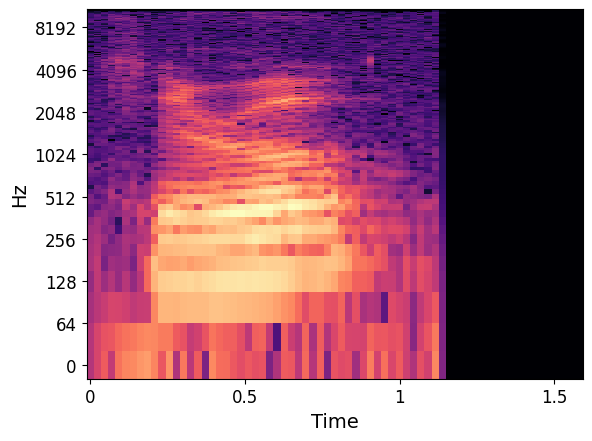

In [5]:
librosa.display.specshow(X_val_features[0].reshape(257, 69), x_axis='time', y_axis='log')

## STFT Amplitude Normalization

In [6]:
def MinMaxScaler(features):
    scaled = []
    min_max_values = []
    for f in features:
        min_val = np.min(f)
        max_val = np.max(f)
        f_normalized = (f - min_val) / (max_val - min_val)
        min_max_values.append((min_val,max_val))
        scaled.append(f_normalized)
    return np.array(scaled),np.array(min_max_values)


def MinMaxUnScaler(features, min_max_values):
    unscaled = []
    for f,min_max in zip(features,min_max_values):
        f = f.reshape(257,69)
        unscaled_feature = (f * (min_max[1] - min_max[0])) + min_max[0]
        unscaled_feature = librosa.db_to_amplitude(unscaled_feature)
        unscaled.append(unscaled_feature)
    return np.array(unscaled)

In [7]:
X_train_features, X_train_min_max  = MinMaxScaler(X_train_features)
X_val_features , X_val_min_max = MinMaxScaler(X_val_features)
X_test_features , X_test_min_max = MinMaxScaler(X_test_features)

In [8]:
print("Shape of training data: ", X_train_features.shape)
print("Shape of test data: ", X_test_features.shape)
print("Shape of validation data: ", X_val_features.shape)

Shape of training data:  (22840, 257, 69, 1)
Shape of test data:  (2820, 257, 69, 1)
Shape of validation data:  (2538, 257, 69, 1)


In [9]:
X_train =  X_train_features
X_test = X_test_features
X_val = X_val_features

In [10]:
print("Shape of training data: ", X_train.shape)
print("Shape of test data: ", X_test.shape)
print("Shape of validation data: ", X_val.shape)

Shape of training data:  (22840, 257, 69, 1)
Shape of test data:  (2820, 257, 69, 1)
Shape of validation data:  (2538, 257, 69, 1)


## VAE with CNN

In [11]:
input_shape = (257,69,1)
latent_dim = 2  # Size of the latent space

In [12]:
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [13]:
def sampling(args):
    z_mean, z_log_var = args
    # return the z mean
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
z = Lambda(sampling)([z_mean, z_log_var])

In [15]:
encoder = Model(inputs, z)
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 257, 69, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 257, 69, 32)          320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 257, 69, 64)          18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 1134912)              0         ['conv2d_1[0][0]']            
                                                                                              

In [16]:
decoder_input = Input(shape=(latent_dim,))
y = Dense(256)(decoder_input)
y = Dense(257 * 69 * 64, activation='relu')(y)
y = Reshape((257, 69, 64))(y)
# y = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(y)
y = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(y)
y = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(y)

In [17]:
decoder_output = y
decoder = Model(decoder_input,y)

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 256)               768       
                                                                 
 dense_4 (Dense)             (None, 1134912)           291672384 
                                                                 
 reshape (Reshape)           (None, 257, 69, 64)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 257, 69, 32)       18464     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 257, 69, 1)        289       
 Transpose)                                                

In [18]:
outputs = decoder(encoder(inputs))

In [19]:
# Define the loss function for VAE
def vae_loss(inputs, outputs):
    xent_loss = K.sum(K.binary_crossentropy(inputs, outputs), axis=(1, 2, 3))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [20]:
cnn_vae = Model(inputs, outputs)
cnn_vae.compile(optimizer='adam', loss=vae_loss)
cnn_vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 257, 69, 1)]      0         
                                                                 
 model (Functional)          (None, 2)                 290557572 
                                                                 
 model_1 (Functional)        (None, 257, 69, 1)        291691905 
                                                                 
Total params: 582249477 (2.17 GB)
Trainable params: 582249477 (2.17 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Train the VAE
cnn_vae_history = cnn_vae.fit(X_train_features, X_train_features, epochs=25, batch_size=128, shuffle=True, validation_data=(X_val_features, X_val_features))

Train on 22840 samples, validate on 2538 samples
Epoch 1/25


2023-12-05 02:03:16.996226: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-12-05 02:03:17.037503: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_3/kernel/v/Assign' id:920 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_3/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_3/kernel/v, training/Adam/dense_3/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


22840/22840 [==============================] - ETA: 0s - loss: nan

/Users/rabinnepal/miniforge3/envs/nn_project_env/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-12-05 02:22:01.539945: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:451 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/model_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


22840/22840 [==============================] - 1151s 50ms/sample - loss: nan - val_loss: nan
Epoch 2/25
22840/22840 [==============================] - 1199s 53ms/sample - loss: nan - val_loss: nan
Epoch 3/25
22840/22840 [==============================] - 1291s 57ms/sample - loss: nan - val_loss: nan
Epoch 4/25
22840/22840 [==============================] - 1311s 57ms/sample - loss: nan - val_loss: nan
Epoch 5/25
22840/22840 [==============================] - 1352s 59ms/sample - loss: nan - val_loss: nan
Epoch 6/25
22840/22840 [==============================] - 1345s 59ms/sample - loss: nan - val_loss: nan
Epoch 7/25
22840/22840 [==============================] - 1350s 59ms/sample - loss: nan - val_loss: nan
Epoch 8/25
 3328/22840 [===>..........................] - ETA: 19:21 - loss: nan

In [26]:
# Evaluate the model on the test data
cnn_vae.evaluate(X_test, X_test)

7737.640894420434

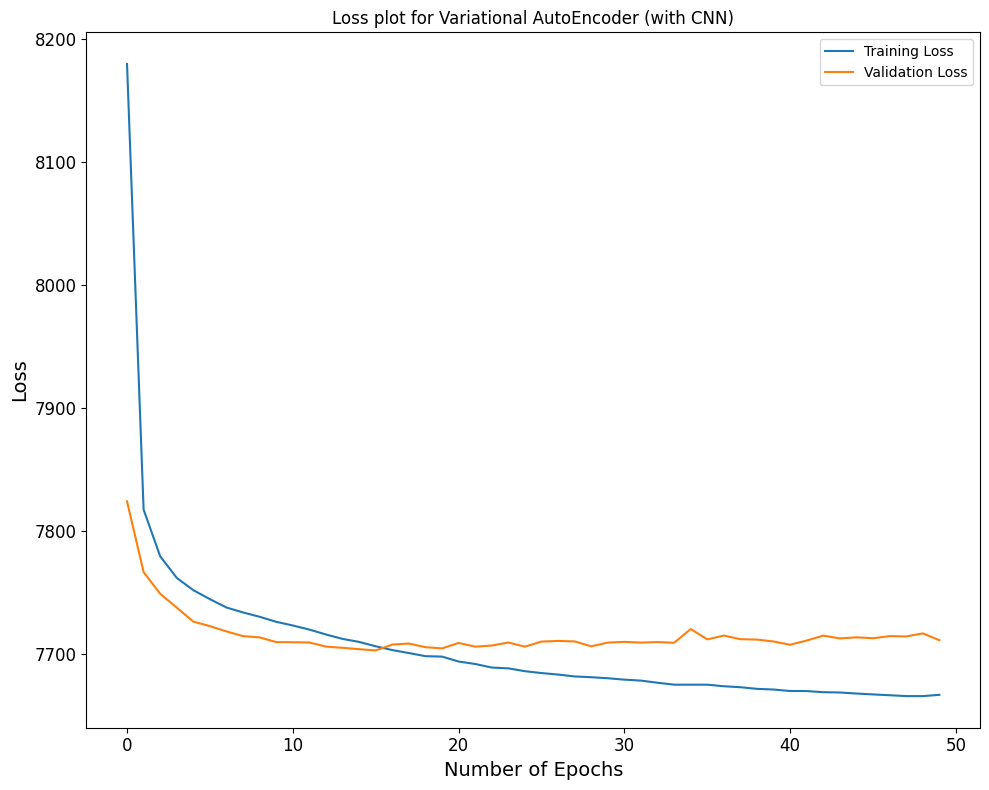

In [27]:
plt.figure(figsize=(10,8))
plt.plot(cnn_loss)
plt.plot(cnn_vae_history.history["val_loss"])
plt.legend(["Training Loss", "Validation Loss"])
plt.title("Loss plot for Variational AutoEncoder (with CNN)")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

In [2]:
latent_space = encoder.predict(X_train)
y_train = [int(y) for y in y_train]
plt.figure(figsize=(10, 9))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=y_train, s=3**2,cmap='viridis',alpha=1)
plt.colorbar()
plt.xlabel('Latent Variable 1 ')
plt.ylabel('Latent Variable 2 ')
plt.title('2D Latent Space Visualization')
plt.tight_layout()
plt.show()


NameError: name 'encoder' is not defined

In [1]:
latent_space = encoder.predict(X_val)
y_val = [int(y) for y in y_val]
plt.figure(figsize=(10, 9))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=y_val, s=3**2,cmap='viridis',alpha=1)
plt.colorbar()
plt.xlabel('Latent Variable 1 ')
plt.ylabel('Latent Variable 2 ')
plt.title('2D Latent Space Visualization')
plt.tight_layout()
plt.show()


NameError: name 'encoder' is not defined

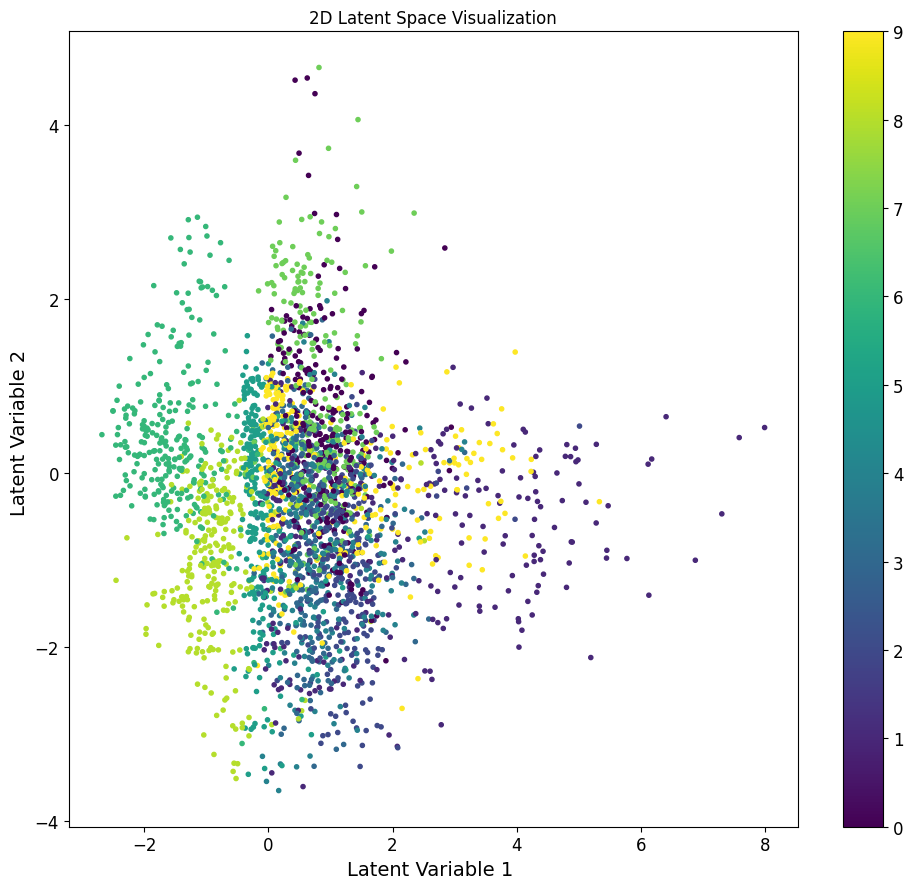

In [29]:
latent_space = encoder.predict(X_test)
y_test = [int(y) for y in y_test]
plt.figure(figsize=(10, 9))
plt.scatter(latent_space[:, 0], latent_space[:, 1], c=y_test, s=3**2,cmap='viridis',alpha=1)
plt.colorbar()
plt.xlabel('Latent Variable 1 ')
plt.ylabel('Latent Variable 2 ')
plt.title('2D Latent Space Visualization')
plt.tight_layout()
plt.show()


### Invserse STFT

In [30]:
def ISTFT(feature):
    audios = []
    for f in tqdm.tqdm(feature,desc="Appling inverse STFT ..."):
        audio = librosa.istft(f,hop_length=256)
        audios.append(audio)
    return np.array(audios)

In [31]:
decoded_stft = cnn_vae.predict(X_val)

/Users/rabinnepal/miniforge3/envs/nn_project_env/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-12-03 18:57:31.737166: W tensorflow/c/c_api.cc:305] Operation '{name:'model_1/conv2d_transpose_1/Sigmoid' id:464 op device:{requested: '', assigned: ''} def:{{{node model_1/conv2d_transpose_1/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](model_1/conv2d_transpose_1/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [32]:
decoded_stft.shape

(2538, 257, 69, 1)

In [33]:
decoded_istft = ISTFT(decoded_stft)

Appling inverse STFT ...: 100%|██████████| 2538/2538 [00:02<00:00, 1149.94it/s]


### Unscale Min Max 

In [34]:
decoded_stft = MinMaxUnScaler(decoded_stft,X_val_min_max)

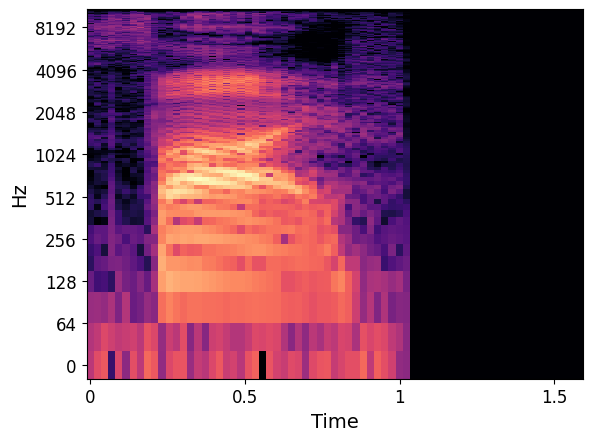

In [35]:

librosa.display.specshow(X_val[1000].reshape(257, 69), x_axis='time', y_axis='log')

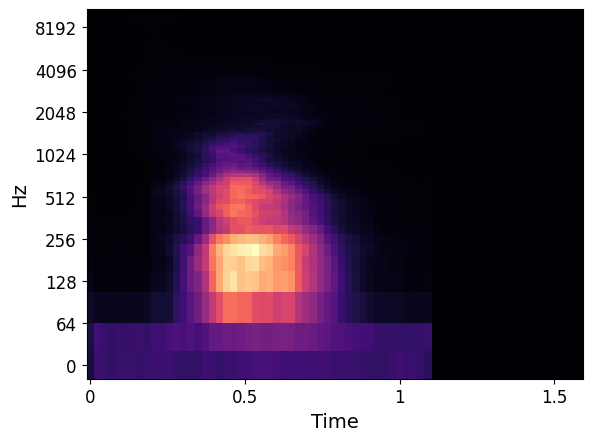

In [36]:
librosa.display.specshow(decoded_stft[1].reshape(257, 69), x_axis='time', y_axis='log')

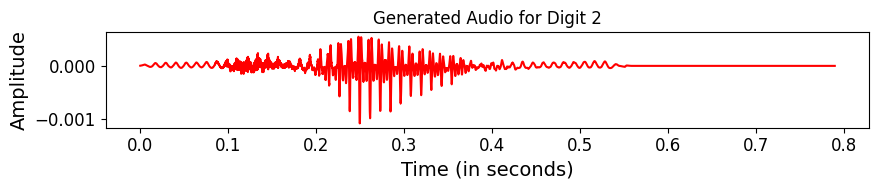

In [38]:
# n = 456 
# n = 900 
# n = 256 
n = 500 
# n = 400

abc = librosa.istft(decoded_stft[n],hop_length=256)

plt.figure(figsize=(9,2))
time_values = np.linspace(0, len(abc)/22050, len(abc))
plt.title("Generated Audio for Digit " + y_val[n])
plt.plot(time_values,abc,color="r")
plt.xlabel("Time (in seconds)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()
Audio(data=abc,rate=22050)

In [ ]:
# sf.output.write_wav("Val_set_900_1.wav", abc, 22050)
sf.write("Val_set_900_1.wav", abc, 22050, format='wav')

## CNN-VAE with Regularization

In [11]:
input_shape = (257,69,1)
latent_dim = 2  # Size of the latent space

In [12]:
# Encoder network
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(inputs)
x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(x)
# x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [13]:
def sampling(args):
    z_mean, z_log_var = args
    # return the z mean
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [14]:
z = Lambda(sampling)([z_mean, z_log_var])

In [15]:
encoder = Model(inputs, z)
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 257, 69, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 257, 69, 32)          320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 257, 69, 64)          18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 1134912)              0         ['conv2d_1[0][0]']            
                                                                                              

In [16]:
decoder_input = Input(shape=(latent_dim,))
y = Dense(256)(decoder_input)
y = Dense(257 * 69 * 64, activation='relu')(y)
y = Reshape((257, 69, 64))(y)
# y = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(y)
y = Conv2DTranspose(32, (3, 3), activation='relu', padding='same',kernel_regularizer=l2(0.001))(y)
y = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(y)

In [17]:
decoder_output = y
decoder = Model(decoder_input,y)

decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 256)               768       
                                                                 
 dense_4 (Dense)             (None, 1134912)           291672384 
                                                                 
 reshape (Reshape)           (None, 257, 69, 64)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 257, 69, 32)       18464     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 257, 69, 1)        289       
 Transpose)                                                

In [18]:
outputs = decoder(encoder(inputs))

In [19]:
# Define the loss function for VAE
def vae_loss(inputs, outputs):
    xent_loss = K.sum(K.binary_crossentropy(inputs, outputs), axis=(1, 2, 3))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [20]:
cnn_vae = Model(inputs, outputs)
cnn_vae.compile(optimizer='adam', loss=vae_loss)
cnn_vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 257, 69, 1)]      0         
                                                                 
 model (Functional)          (None, 2)                 290557572 
                                                                 
 model_1 (Functional)        (None, 257, 69, 1)        291691905 
                                                                 
Total params: 582249477 (2.17 GB)
Trainable params: 582249477 (2.17 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Train the VAE
cnn_vae_history = cnn_vae.fit(X_train_features, X_train_features, epochs=25, batch_size=128, shuffle=True, validation_data=(X_val_features, X_val_features))

Train on 22840 samples, validate on 2538 samples
Epoch 1/25


2023-12-05 00:54:57.924730: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-12-05 00:54:57.968285: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_3/bias/v/Assign' id:961 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_3/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_3/bias/v, training/Adam/dense_3/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


 1408/22840 [>.............................] - ETA: 21:55 - loss: nan

KeyboardInterrupt: 